# AutoEncoders

## Basically we let our model to automatically encode our image/matrix
## and also decode it

## It is unsupervised

### This method is lossy
### This provides some compression to our image/matrix
#### Out priority here isn't compression instead it is to reduce features

### We can also use autoencoders to remove noise from our image/matrix

X_train shape:  (60000, 784)
X_test shape:  (10000, 784)
Epoch 1/50
235/235 [==============================] - 2s 8ms/step - loss: 0.6924 - val_loss: 0.6924
Epoch 2/50
235/235 [==============================] - 2s 7ms/step - loss: 0.6923 - val_loss: 0.6922
Epoch 3/50
235/235 [==============================] - 2s 6ms/step - loss: 0.6921 - val_loss: 0.6920
Epoch 4/50
235/235 [==============================] - 2s 7ms/step - loss: 0.6919 - val_loss: 0.6919
Epoch 5/50
235/235 [==============================] - 2s 7ms/step - loss: 0.6918 - val_loss: 0.6917
Epoch 6/50
235/235 [==============================] - 2s 8ms/step - loss: 0.6916 - val_loss: 0.6915
Epoch 7/50
235/235 [==============================] - 2s 7ms/step - loss: 0.6914 - val_loss: 0.6913
Epoch 8/50
235/235 [==============================] - 2s 7ms/step - loss: 0.6913 - val_loss: 0.6912
Epoch 9/50
235/235 [==============================] - 2s 8ms/step - loss: 0.6911 - val_loss: 0.6910
Epoch 10/50
235/235 [======================

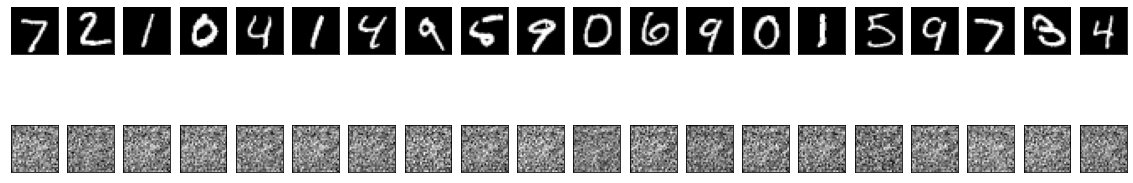

In [2]:
import numpy as np
from keras.layers import Input, Dense 
from keras.models import Model
from keras.datasets import mnist
import matplotlib.pyplot as plt

# this is the size of our encoded representations
encoding_dim = 32 # 32 floats -> compression of factor 24.5, assuming the input is 784

# this is our input placeholder
input_img = Input(shape=(784,))
# 'encoded' is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)
# 'decoded' is the lossy reconstruction of the input
decoded = Dense(784, activation='sigmoid')(encoded)
# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)
# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)
# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))
# configure our model to use a per-pixel binary crossentropy loss, and the Adadelta optimizer
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

# prepare our input data. We're using MNIST digits, and we're discarding the labels
(X_train, _), (X_test, _) = mnist.load_data()
# normalizer all values between 0 and 1 and we will faltten the 28x28 images into vecotrs
X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.
X_train = X_train.reshape((len(X_train), np.prod(X_train.shape[1:])))
X_test = X_test.reshape((len(X_test), np.prod(X_test.shape[1:])))
print('X_train shape: ',X_train.shape)
print('X_test shape: ', X_test.shape)

# Train our autoencoder for 50 epochs
autoencoder.fit(X_train, X_train, epochs=50,
batch_size=256, shuffle=True, validation_data=(X_test, X_test))
# we have used both input as X_test in validation_data because it is unsupervised model.

# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(X_test)
decoded_imgs = decoder.predict(encoded_imgs)

# Visualize the reconstructed inputs and the encoded representations.use Matplotlib
n = 20 # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display orignal
    ax = plt.subplot(2, n, i+1)
    plt.imshow(X_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i+1+n)
    plt.imshow(decoded_imgs[i].reshape(28,28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()



# Convolutional autoencoders

In [4]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K
from keras.datasets import mnist
import numpy as np
from keras.callbacks import TensorBoard
import matplotlib.pyplot as plt

input_img = Input(shape=(28, 28, 1)) # adapt this if using 'channels_first' images data format

X = Conv2D(16, (3,3), activation='relu', padding='same')(input_img)
X = MaxPooling2D((2,2), padding='same')(X)
X = Conv2D(8, (3,3), activation='relu', padding='same')(X)
X = MaxPooling2D((2,2), padding='same')(X)
X = Conv2D(8, (3,3), activation='relu', padding='same')(X)
encoded = MaxPooling2D((2,2), padding='same')(X)

# normally we first create an instance of model(mostly sequential)
# and then add every layer

# but here we are doing by adding layers to a var (X in this case)
# so when we write X in the end of each line to add/ stack layers

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

X = Conv2D(8, (3,3), activation='relu', padding='same')(encoded)
X = UpSampling2D((2,2))(X)
X = Conv2D(8, (3,3), activation='relu', padding='same')(X)
X = UpSampling2D((2,2))(X)
X = Conv2D(16,  (3,3), activation='relu')(X)
X = UpSampling2D((2,2))(X)
decoded = Conv2D(1, (3,3), activation='sigmoid', padding='same')(X)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

(X_train, _), (X_test, _) = mnist.load_data()

X_train = X_train.astype('float32')/ 255.
X_test = X_test.astype('float32')/ 255.
X_train = np.reshape(X_train, (len(X_train), 28, 28, 1)) # adapt this if using 'channels_first' images data format
X_test = np.reshape(X_test, (len(X_test), 28, 28, 1)) # adapt this if using 'channels_first' images data format

import tensorflow as tf

# Runnin on GPU
with tf.device('/gpu:0'):
    autoencoder.fit(X_train, X_train, epochs = 20, batch_size=128, shuffle=True, validation_data=(X_test, X_test),
                    callbacks = [TensorBoard(log_dir='/tmp/autoencoder')])

decoded_imgs = autoencoder.predict(X_test)



Epoch 1/50
469/469 [==============================] - 58s 121ms/step - loss: 0.6883 - val_loss: 0.6859
Epoch 2/50
469/469 [==============================] - 52s 111ms/step - loss: 0.6828 - val_loss: 0.6792
Epoch 3/50
469/469 [==============================] - 49s 105ms/step - loss: 0.6740 - val_loss: 0.6676
Epoch 4/50
469/469 [==============================] - 48s 101ms/step - loss: 0.6567 - val_loss: 0.6423
Epoch 5/50
469/469 [==============================] - 48s 102ms/step - loss: 0.6146 - val_loss: 0.5777
Epoch 6/50
469/469 [==============================] - 48s 102ms/step - loss: 0.5334 - val_loss: 0.5044
Epoch 7/50
469/469 [==============================] - 48s 102ms/step - loss: 0.4945 - val_loss: 0.4927
Epoch 8/50
469/469 [==============================] - 49s 104ms/step - loss: 0.4861 - val_loss: 0.4855
Epoch 9/50
469/469 [==============================] - 48s 103ms/step - loss: 0.4787 - val_loss: 0.4779
Epoch 10/50
469/469 [==============================] - 48s 103ms/step - l

ValueError: num must be 1 <= num <= 20, not 0

<Figure size 1440x288 with 0 Axes>

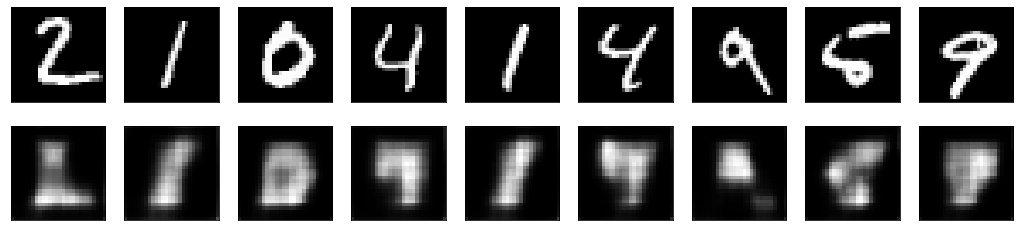

In [6]:
n = 11
plt.figure(figsize=(20, 4))
for i in range(1,n):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(X_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i+n)
    plt.imshow(decoded_imgs[i].reshape(28,28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

# Autoencoder Practical Application: Image Denoising

In [11]:
from keras.layers import Input, Dense, Conv2D, MaxPool2D, UpSampling2D
from keras.models import Model
from keras.callbacks import TensorBoard
from keras.datasets import mnist
import numpy as np
from keras import backend as K
import matplotlib.pyplot as plt

input_img = Input(shape=(28, 28, 1)) # adapt this if using 'channels_first' image data format

X = Conv2D(32, (3, 3), activation ='relu', padding='same')(input_img)
X = MaxPool2D((2,2), padding='same')(X)
X = Conv2D(32, (3, 3), activation='relu', padding='same')(X)
encoded = MaxPool2D((2, 2), padding='same')(X)

# at this point the representation is (7, 7, 32)

X = Conv2D(32, (3,3), activation='relu', padding='same')(encoded)
X = UpSampling2D((2,2))(X)
X = Conv2D(32, (3, 3), activation='relu', padding='same')(X)
X = UpSampling2D((2,2))(X)
decoded = Conv2D(1, (3,3), activation='sigmoid', padding='same')(X)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

(X_train, _), (X_test, _) = mnist.load_data()

X_train = X_train.astype('float32')/ 255.
X_test = X_test.astype('float32')/ 255.
X_train = np.reshape(X_train, (len(X_train), 28, 28, 1)) # adapt this if using 'channels_first' images data format
X_test = np.reshape(X_test, (len(X_test), 28, 28, 1)) # adapt this if using 'channels_first' images data format

noise_factor = 0.5
X_train_noisy = X_train + noise_factor + np.random.normal(loc=0.0, scale=1.0, size=X_train.shape)
X_test_noisy = X_test + noise_factor + np.random.normal(loc=0.0, scale=1.0, size=X_test.shape)

X_train_noisy = np.clip(X_train_noisy, 0., 1.)
X_test_noisy = np.clip(X_test_noisy, 0., 1.)


autoencoder.fit(X_train_noisy, 
                    X_train, epochs=20, 
                    batch_size=128, 
                    shuffle=True,
                    validation_data=(X_test_noisy, X_test), 
                    callbacks=[TensorBoard(log_dir='/tmp/tb', 
                    histogram_freq=0, 
                    write_graph=False)])

decoded_imgs = autoencoder.predict(X_test)

  

Epoch 1/20
469/469 [==============================] - 92s 195ms/step - loss: 0.6735 - val_loss: 0.6525
Epoch 2/20
469/469 [==============================] - 98s 208ms/step - loss: 0.6117 - val_loss: 0.5619
Epoch 3/20
469/469 [==============================] - 95s 204ms/step - loss: 0.5157 - val_loss: 0.4905
Epoch 4/20
469/469 [==============================] - 94s 200ms/step - loss: 0.4797 - val_loss: 0.4776
Epoch 5/20
469/469 [==============================] - 93s 199ms/step - loss: 0.4689 - val_loss: 0.4670
Epoch 6/20
469/469 [==============================] - 85s 181ms/step - loss: 0.4577 - val_loss: 0.4547
Epoch 7/20
469/469 [==============================] - 78s 165ms/step - loss: 0.4436 - val_loss: 0.4390
Epoch 8/20
469/469 [==============================] - 82s 175ms/step - loss: 0.4274 - val_loss: 0.4214
Epoch 9/20
469/469 [==============================] - 88s 187ms/step - loss: 0.4079 - val_loss: 0.3996
Epoch 10/20
469/469 [==============================] - 81s 173ms/step - l

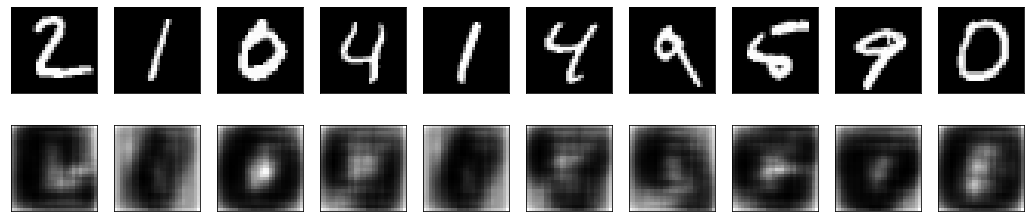

In [13]:
n = 11
plt.figure(figsize=(20, 4))
for i in range(1, n):
    #display orignal
    ax = plt.subplot(2, n, i)
    plt.imshow(X_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i+n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()  
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()